# Efficient Frontier Project of 10 Indian Stocks using MPT

In [122]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
%matplotlib inline

plt.style.use('fivethirtyeight')
np.random.seed(40)




In [123]:

df = yf.download(['TCS.BO','INFY.BO','MARUTI.BO','HEROMOTOCO.BO','ICICIBANK.BO','HDFCBANK.BO','ONGC.BO','GAIL.BO','DRREDDY.BO','CIPLA.BO'],start="2017-04-01",end="2022-04-01")

weights = [0.15,0.2,0.05,0.15,0.05,0.1,0.05,0.025,0.125,0.1]

df = df[['Adj Close']]

df = df.stack()
df = df.reset_index()
df = df.set_index('Date')
df.columns = ['ticker','close']
df.head()


[*********************100%***********************]  10 of 10 completed


,ticker,close
Date,,
2017-04-03,CIPLA.BO,575.919800
2017-04-03,DRREDDY.BO,2604.868652
2017-04-03,GAIL.BO,116.390610
2017-04-03,HDFCBANK.BO,690.125061
2017-04-03,HEROMOTOCO.BO,2678.564697


In [124]:
df.describe(include='all')

,ticker,close
count,12350,12350.000000
unique,10,NaN
top,CIPLA.BO,NaN
freq,1235,NaN
mean,NaN,1862.022665
std,NaN,2115.059503
min,NaN,51.642056
25%,NaN,377.238457
50%,NaN,985.330444
75%,NaN,2561.474670


In [125]:
df['ticker'] = df.ticker.str.split('.').str.get(0)
tickers = []
tickers = df.ticker.unique()
tickers

array(['CIPLA', 'DRREDDY', 'GAIL', 'HDFCBANK', 'HEROMOTOCO', 'ICICIBANK',
       'INFY', 'MARUTI', 'ONGC', 'TCS'], dtype=object)

In [126]:
df = df.reset_index()
df = df.pivot(index='Date',columns = 'ticker', values='close')
df

ticker,CIPLA,DRREDDY,GAIL,HDFCBANK,HEROMOTOCO,ICICIBANK,INFY,MARUTI,ONGC,TCS
Date,,,,,,,,,,
2017-04-03,575.919800,2604.868652,116.390610,690.125061,2678.564697,251.163651,436.797150,5699.738281,146.044464,1086.734009
2017-04-05,576.795715,2595.335693,115.619820,690.462280,2671.585938,249.499481,430.717560,5950.401367,146.437607,1082.028198
2017-04-06,573.145996,2571.669678,116.934715,691.666504,2679.108398,245.995850,432.340271,5899.667969,147.184555,1080.632202
2017-04-07,572.999878,2520.922852,116.844025,693.039307,2688.510986,242.623642,424.594788,5879.581543,146.516235,1092.948364
2017-04-10,572.805237,2500.529785,116.345306,690.558533,2674.176514,243.192993,412.349152,5875.028809,146.555557,1090.269043
...,...,...,...,...,...,...,...,...,...,...
2022-03-25,1008.451050,4302.333008,146.641800,1415.288208,2318.992432,694.980469,1856.746094,7370.888184,175.800003,3673.443115
2022-03-28,1013.426880,4224.147461,151.061432,1416.425049,2317.383545,706.014282,1853.826904,7427.961914,176.399994,3671.560791
2022-03-29,1033.778076,4263.413574,151.607666,1436.244385,2153.325684,710.984436,1866.146606,7389.216797,171.050003,3670.470947


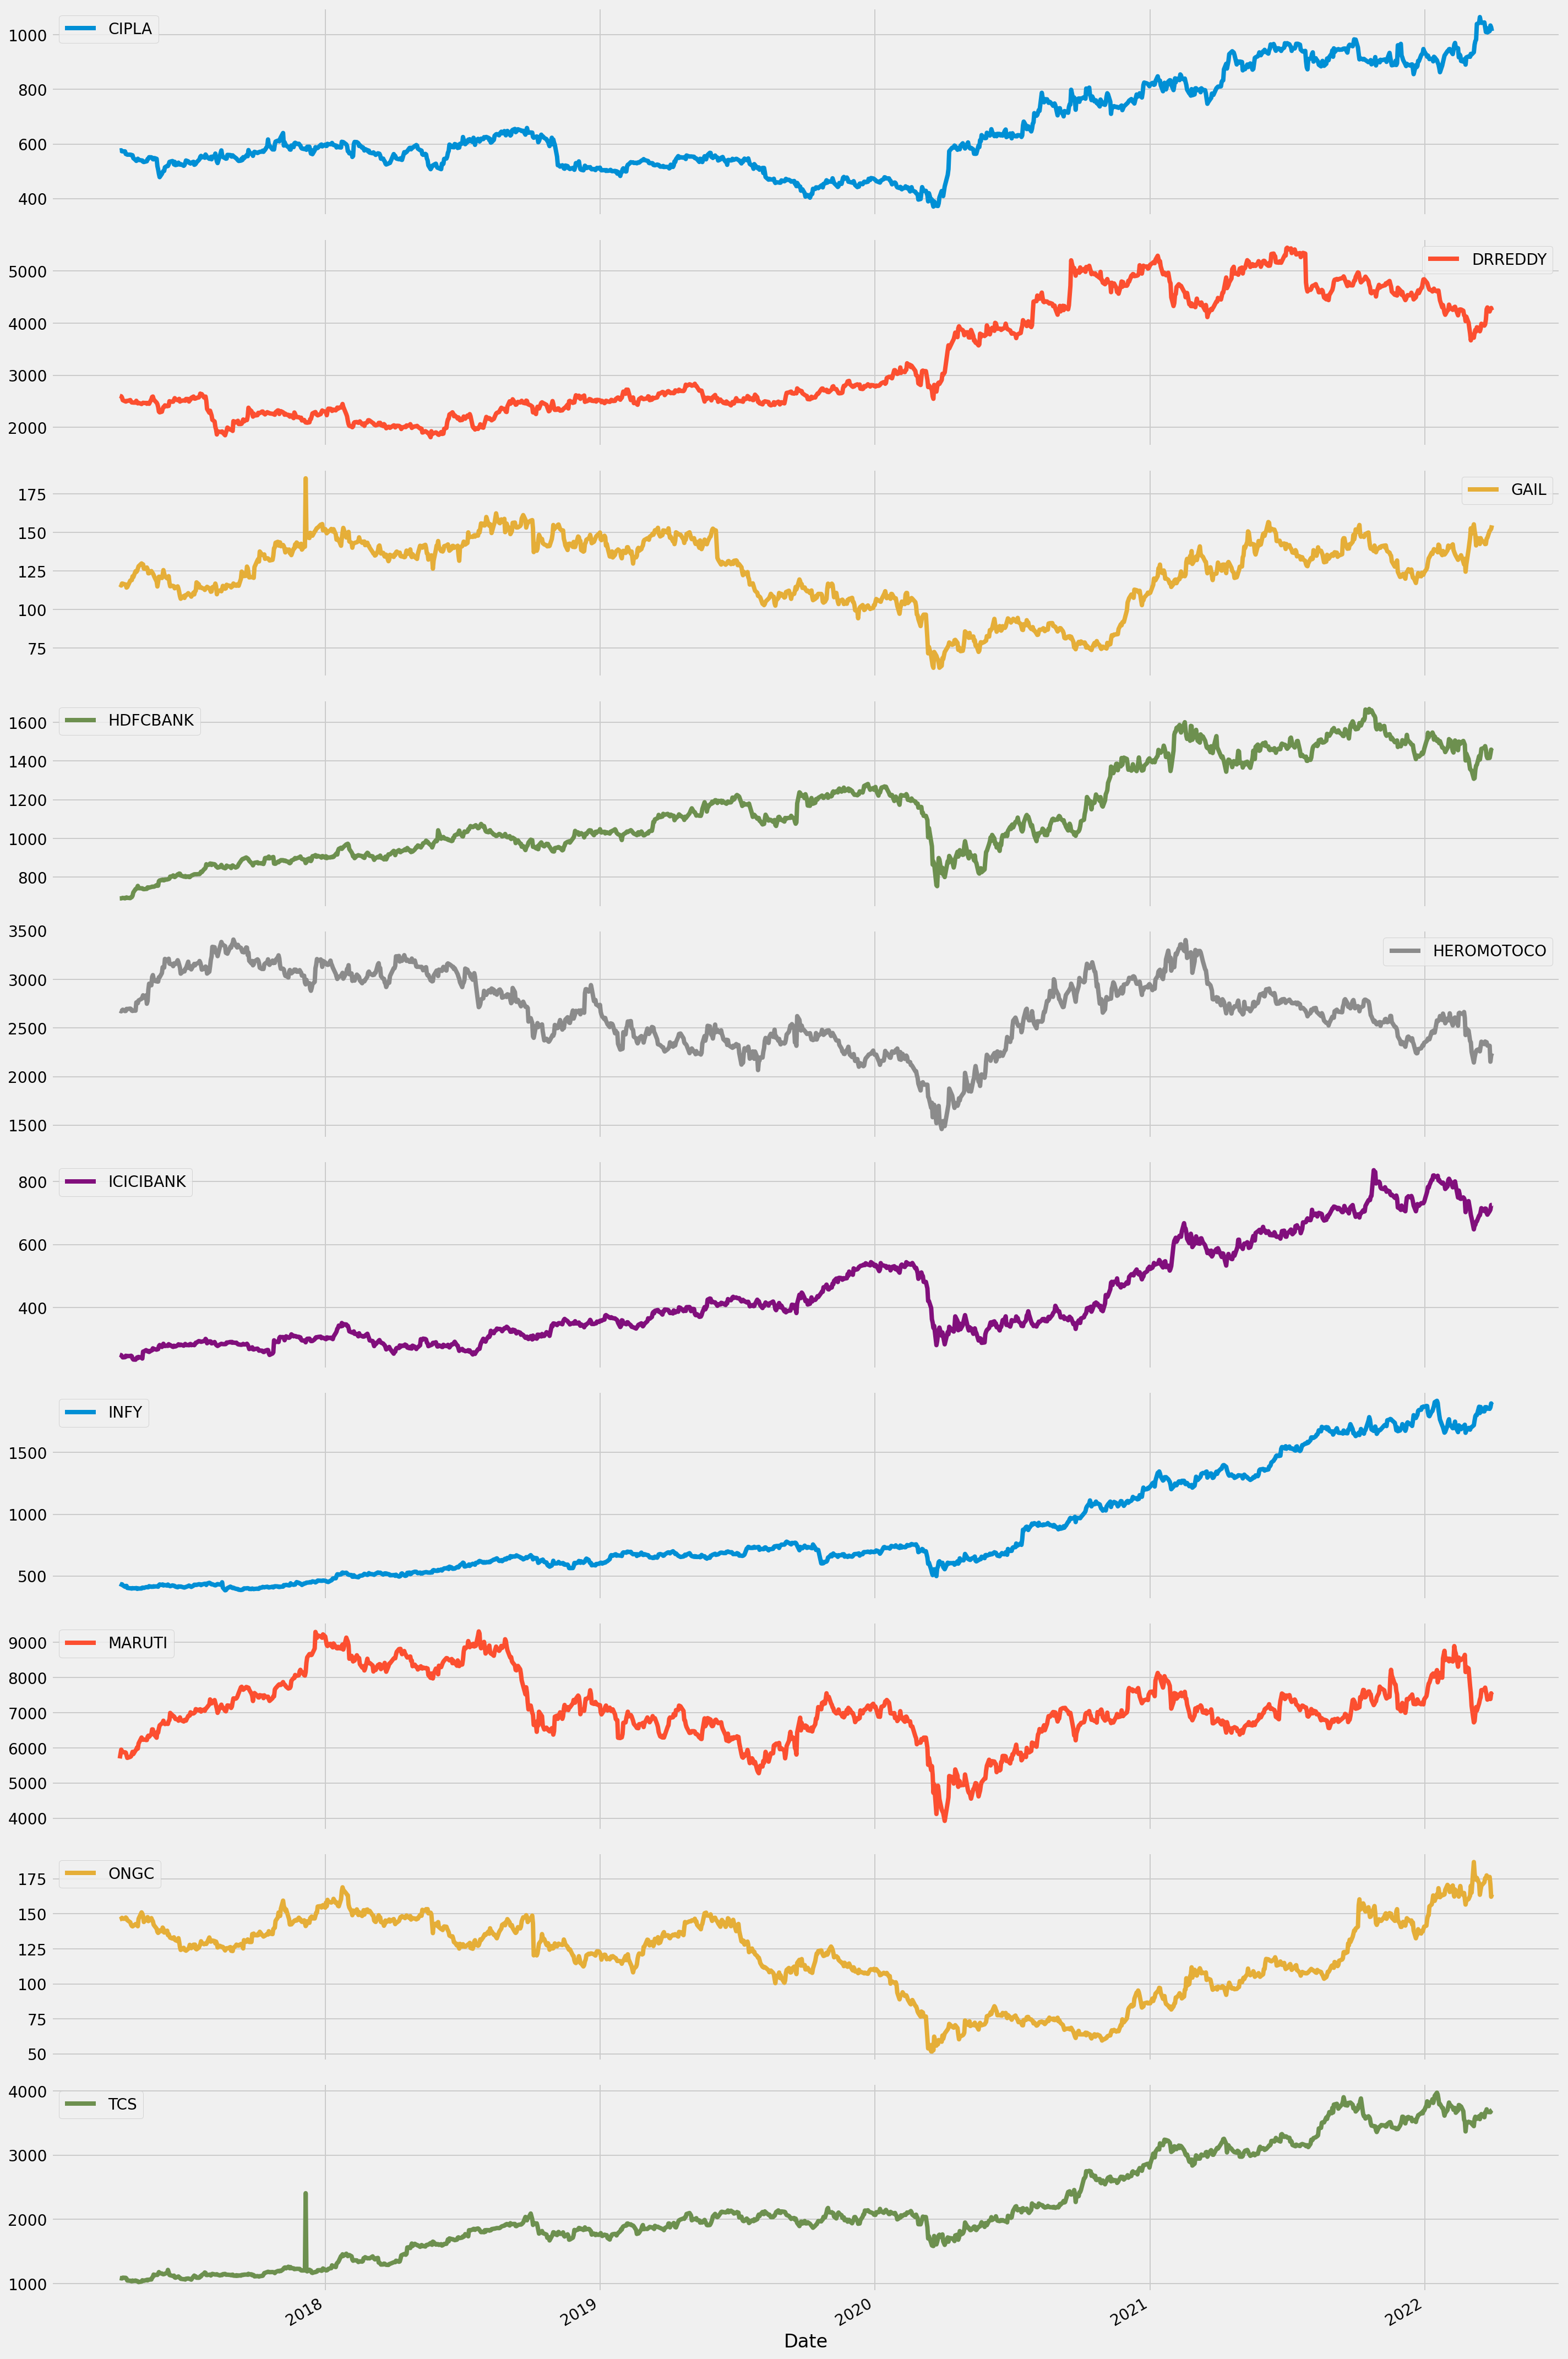

In [127]:
df.plot(subplots= True, figsize=(20,30))
plt.tight_layout()

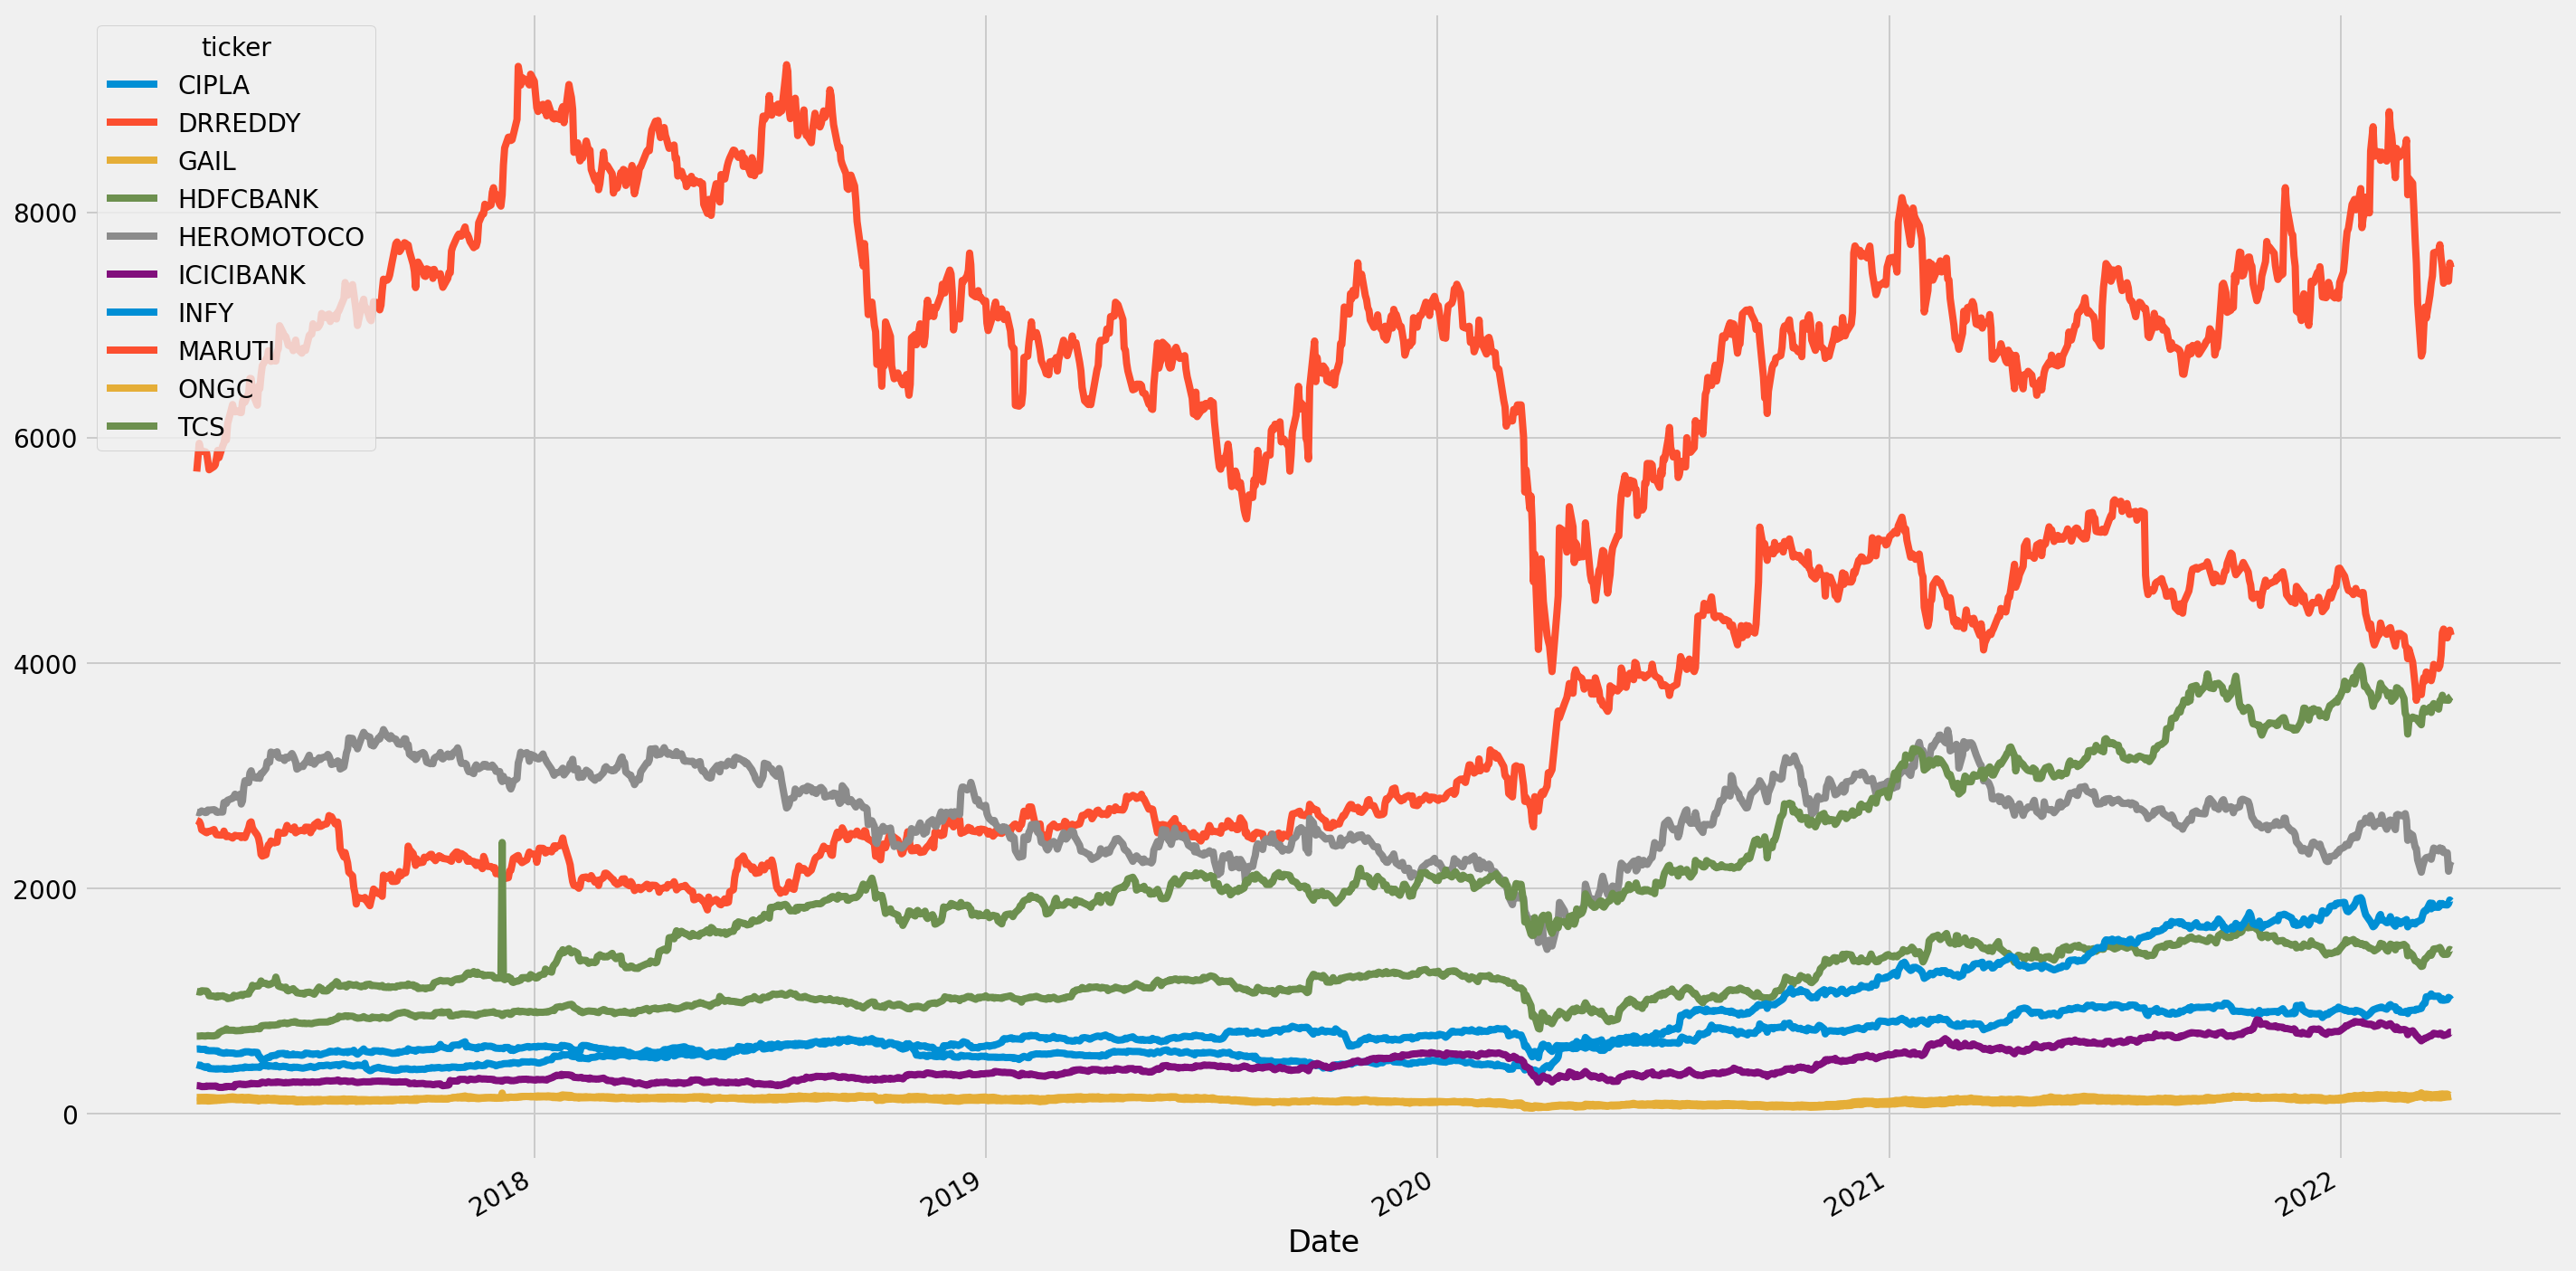

In [128]:
df.plot(figsize=(20,10) )
plt.tight_layout()

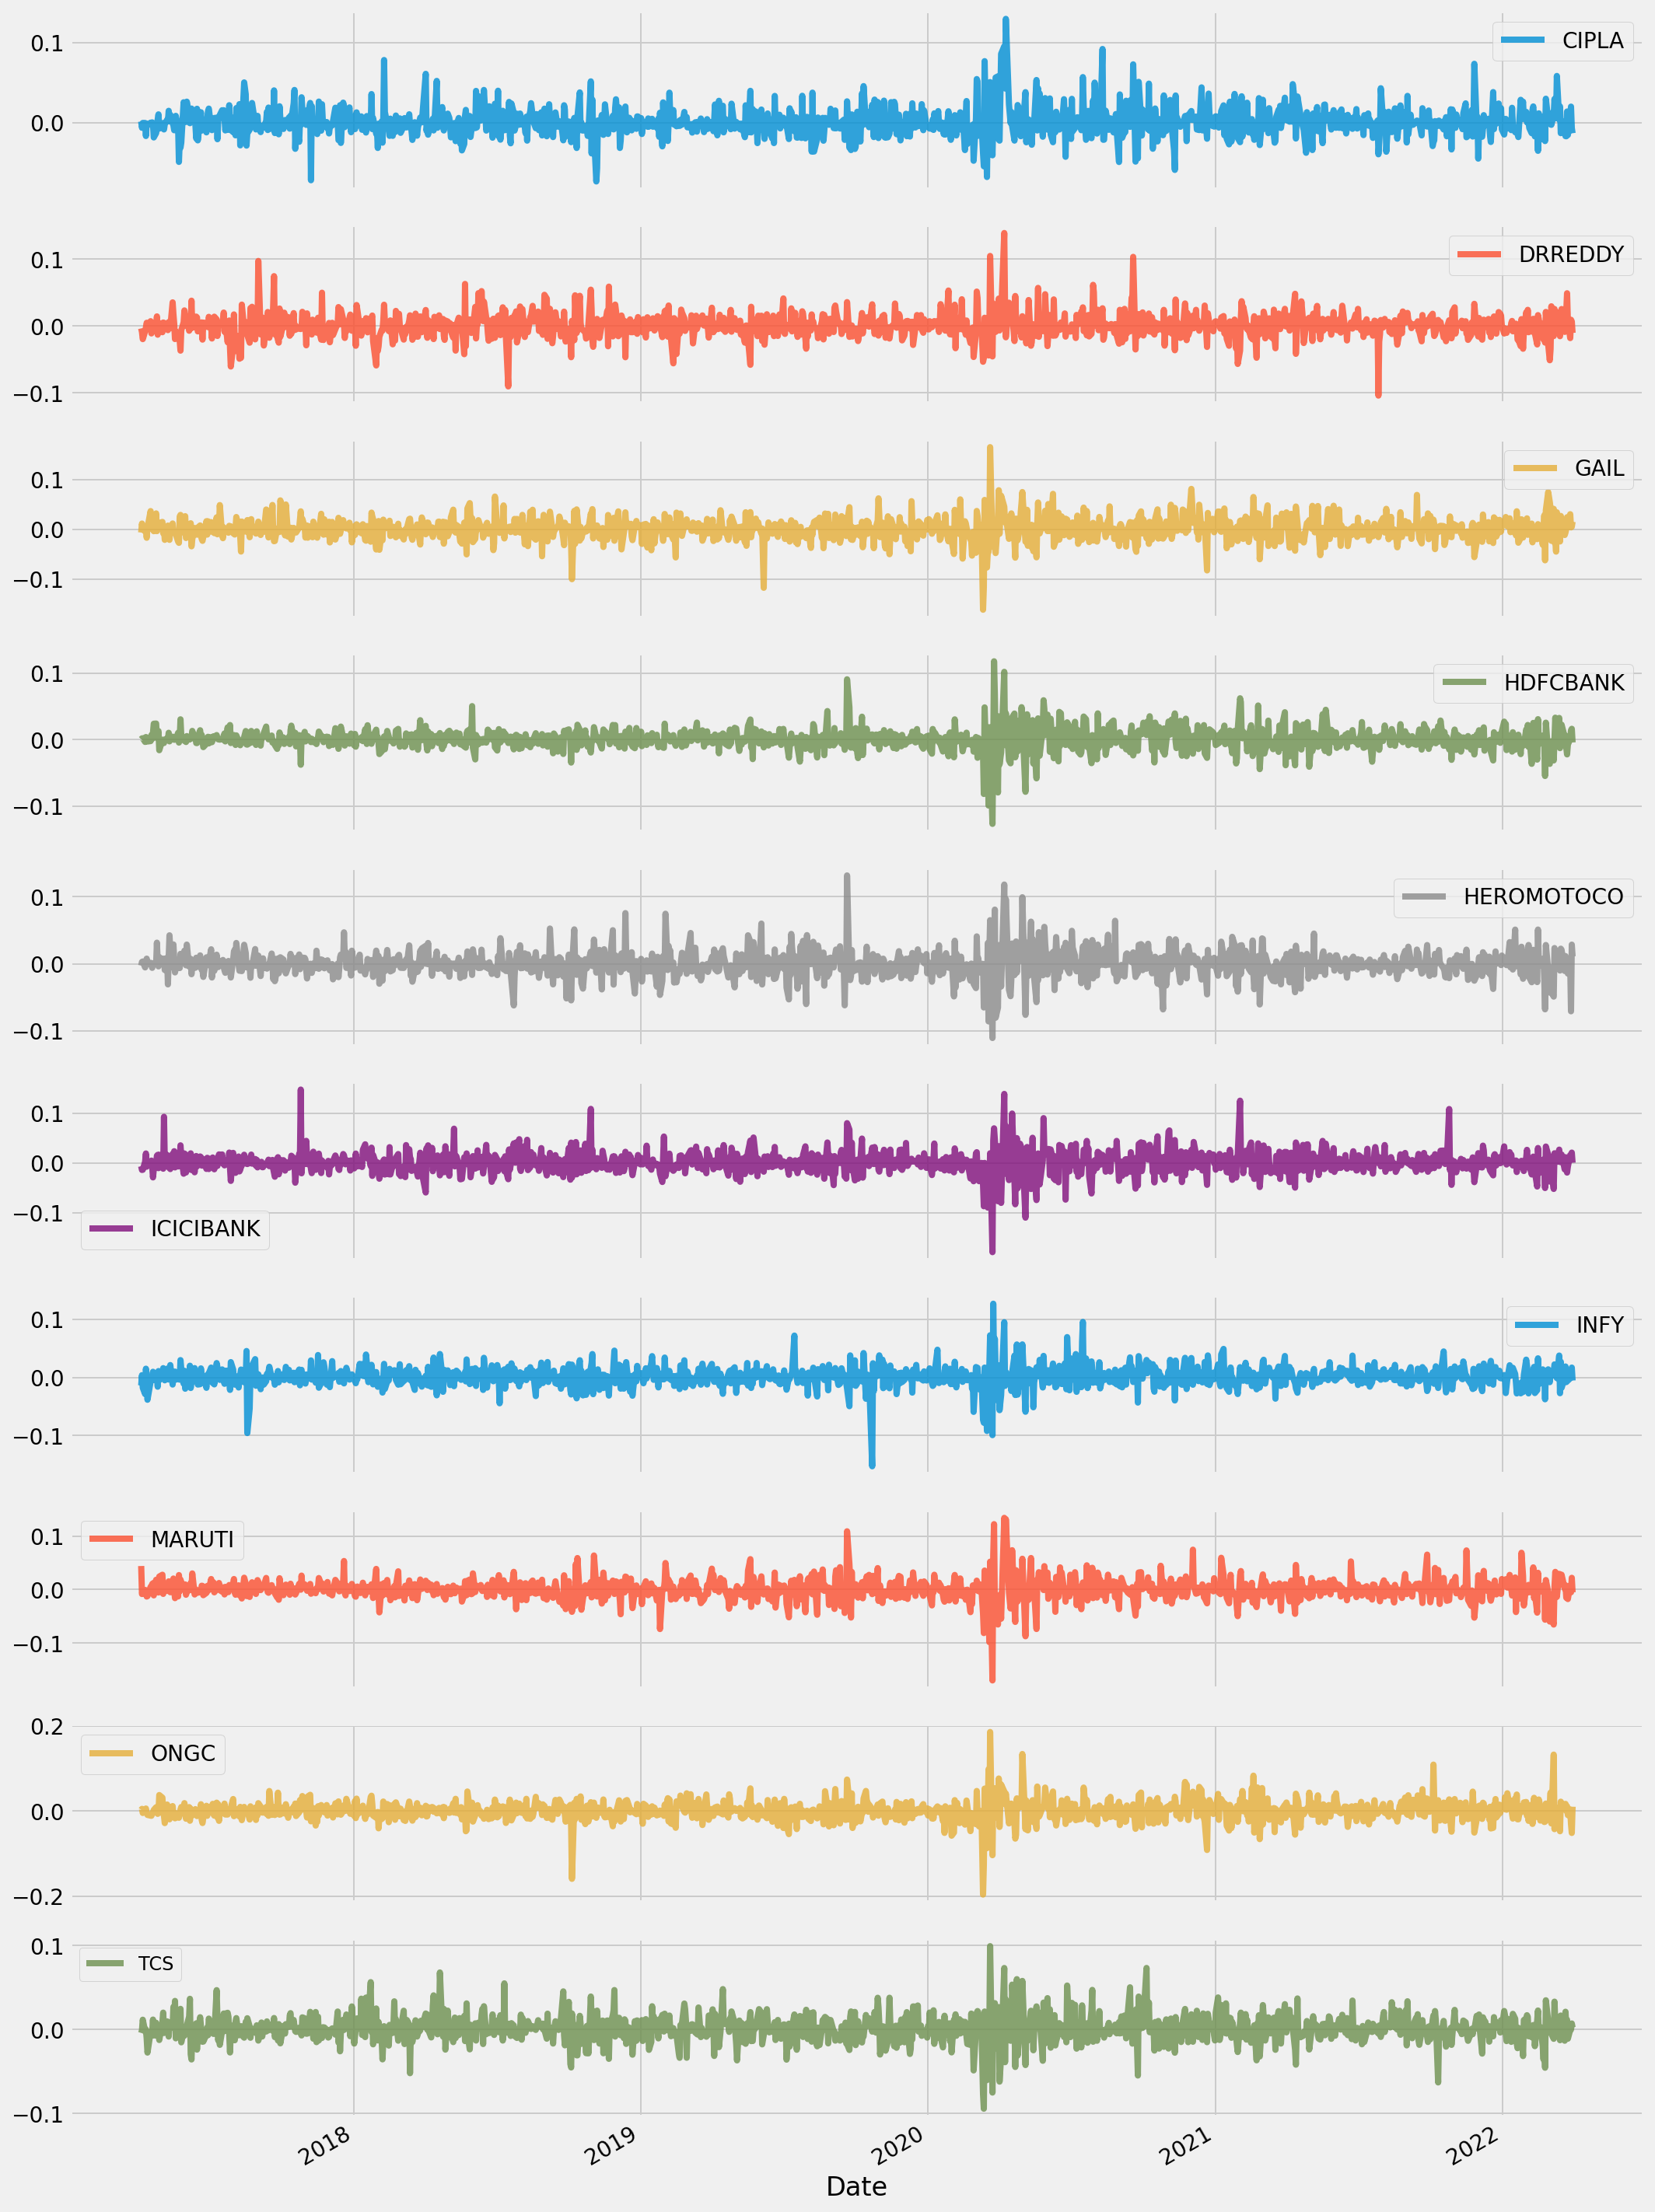

In [129]:
returns = df.pct_change()

dropindex = []

dropindex.extend(returns[returns.TCS > 0.8].index)

dropindex.extend(returns[returns.TCS < (-0.5)].index)


returns.drop(index = dropindex, axis = 0, inplace = True)


returns.plot(figsize=(15,20), alpha = 0.8, subplots = True)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

In [130]:
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.073

## Simulating Random Frontier 

In [131]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [143]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2)*100, '%')
    print("Annualised Volatility:", round(sdp,2)*100,  '%')
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2)*100,  '%')
    print("Annualised Volatility:", round(sdp_min,2)*100,  '%')
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 25.0 %
Annualised Volatility: 19.0 %


ticker      CIPLA  DRREDDY  GAIL  HDFCBANK  HEROMOTOCO  ICICIBANK   INFY  \
allocation   3.93    11.13  0.21      8.32        0.66      18.19  25.13   

ticker      MARUTI  ONGC    TCS  
allocation     3.7  4.28  24.45  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 18.0 %
Annualised Volatility: 17.0 %


ticker      CIPLA  DRREDDY  GAIL  HDFCBANK  HEROMOTOCO  ICICIBANK  INFY  \
allocation  19.29    13.81  5.81     22.27        9.12       0.28  6.27   

ticker      MARUTI  ONGC    TCS  
allocation    1.14  2.91  19.11  


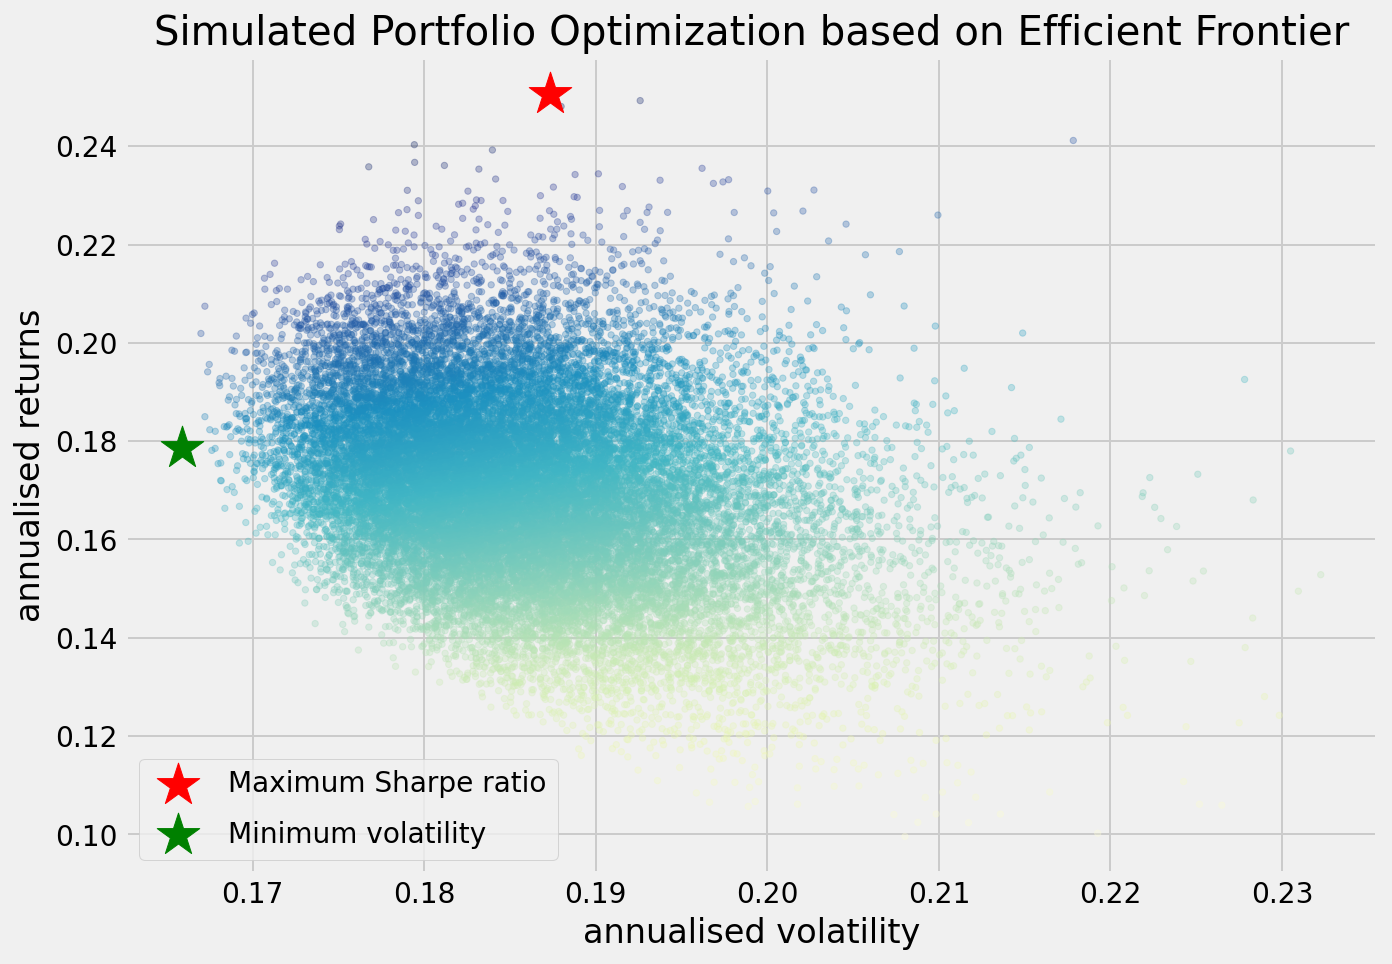

In [144]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [134]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [135]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result


In [136]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [137]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.22


ticker      CIPLA  DRREDDY  GAIL  HDFCBANK  HEROMOTOCO  ICICIBANK   INFY  \
allocation   5.08      0.0   0.0       0.0         0.0      18.72  44.08   

ticker      MARUTI  ONGC    TCS  
allocation     0.0   0.0  32.13  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.19
Annualised Volatility: 0.17


ticker      CIPLA  DRREDDY  GAIL  HDFCBANK  HEROMOTOCO  ICICIBANK  INFY  \
allocation  17.33     14.8  7.64     24.28        4.69        0.0  7.84   

ticker      MARUTI  ONGC    TCS  
allocation    1.08  2.22  20.12  


/var/folders/0r/2stkv5315vd8k221nlnxpz6m0000gn/T/ipykernel_1326/1111117204.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


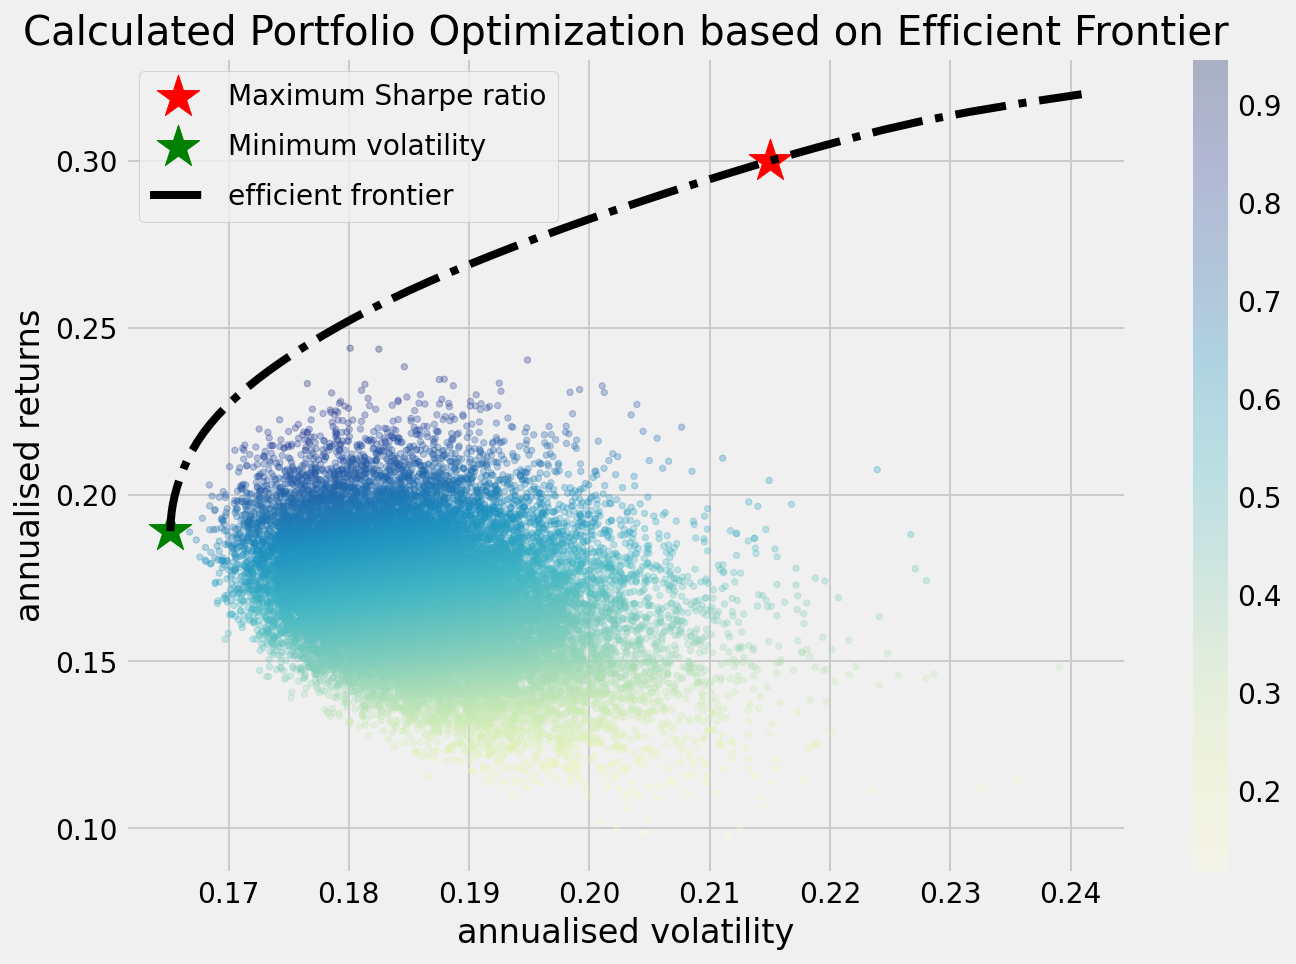

In [138]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [139]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    print( "-"*80)
    print( "Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(df.columns):
        print( txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(df.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.22


ticker      CIPLA  DRREDDY  GAIL  HDFCBANK  HEROMOTOCO  ICICIBANK   INFY  \
allocation   5.08      0.0   0.0       0.0         0.0      18.72  44.08   

ticker      MARUTI  ONGC    TCS  
allocation     0.0   0.0  32.13  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.19
Annualised Volatility: 0.17


ticker      CIPLA  DRREDDY  GAIL  HDFCBANK  HEROMOTOCO  ICICIBANK  INFY  \
allocation  17.33     14.8  7.64     24.28        4.69        0.0  7.84   

ticker      MARUTI  ONGC    TCS  
allocation    1.08  2.22  20.12  
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

CIPLA : annuaised return 0.16 , annualised volatility: 0.28
DRREDDY : annuaised retur

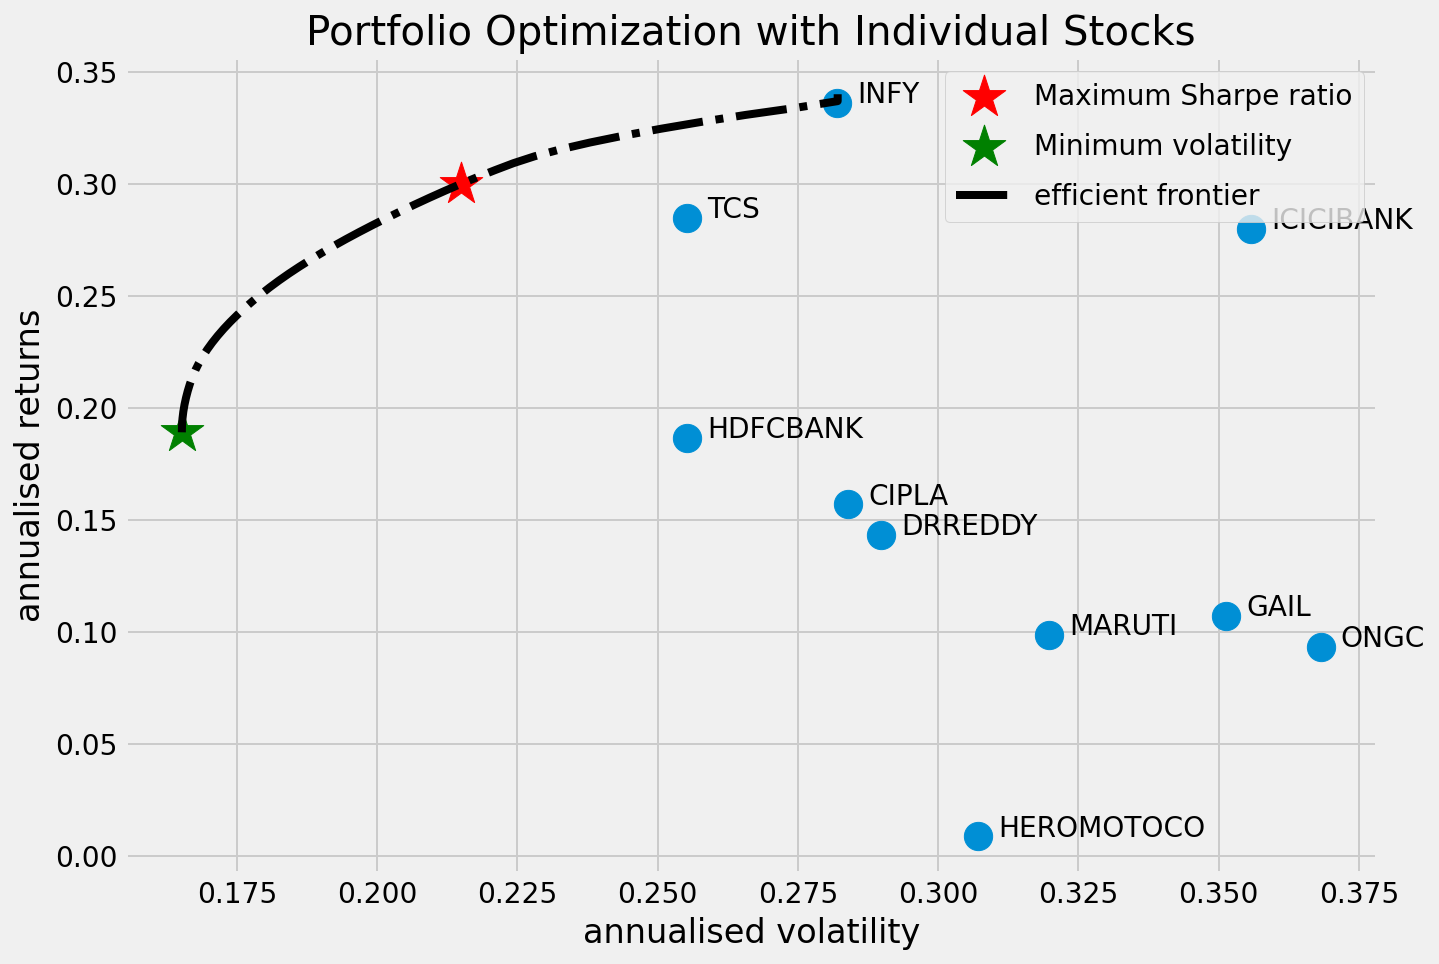

In [140]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)
